In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json 
from collections import Counter
import re

In [3]:
# Load the dataset
file_path = 'Magazine_Subscriptions.jsonl'
reviews = []
with open(file_path, 'r') as file:
    for line in file:
        reviews.append(json.loads(line))
reviews_df = pd.DataFrame(reviews)

# Step 1: Label Sentiments
def label_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

reviews_df['sentiment'] = reviews_df['rating'].apply(label_sentiment)

# Sample the data for efficiency
sample_df = reviews_df.sample(n=30000, random_state=42)
X_sample = sample_df['text']
y_sample = sample_df['sentiment']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)


positive_count = reviews_df[reviews_df['sentiment'] == "Positive"].shape[0]
print(f"Number of Positive reviews: {positive_count}")

positive_count = reviews_df[reviews_df['sentiment'] == "Negative"].shape[0]
print(f"Number of Positive reviews: {positive_count}")

positive_count = reviews_df[reviews_df['sentiment'] == "Neutral"].shape[0]
print(f"Number of Positive reviews: {positive_count}")

Number of Positive reviews: 52826
Number of Positive reviews: 13638
Number of Positive reviews: 5033


In [22]:
print(f"Total records loaded: {len(reviews)}")

fields = reviews[0].keys()
print(f"Example fields in the data: {fields}")

ratings = [item.get("rating", None) for item in reviews]
print(f"Number of reviews with ratings: {len([r for r in ratings if r is not None])}")
print(f"Unique ratings: {set(ratings)}")

rating_counts = Counter(ratings)
print("Frequency of ratings (sorted):")
for rating, count in sorted(rating_counts.items()):
    print(f"Rating {rating}: {count}")

review_lengths = [len(item.get("text", "")) for item in reviews if "text" in item]
average_review_length = sum(review_lengths) / len(review_lengths) if review_lengths else 0
print(f"\nAverage review length (characters): {average_review_length:.2f}")

helpful_votes = [item.get("helpful_vote", 0) for item in reviews]
average_helpful_votes = sum(helpful_votes) / len(helpful_votes) if helpful_votes else 0
print(f"\nAverage helpful votes per review: {average_helpful_votes:.2f}")

Total records loaded: 71497
Example fields in the data: dict_keys(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'])
Number of reviews with ratings: 71497
Unique ratings: {1.0, 2.0, 3.0, 4.0, 5.0}
Frequency of ratings (sorted):
Rating 1.0: 9685
Rating 2.0: 3953
Rating 3.0: 5033
Rating 4.0: 8206
Rating 5.0: 44620

Average review length (characters): 217.17

Average helpful votes per review: 4.45


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


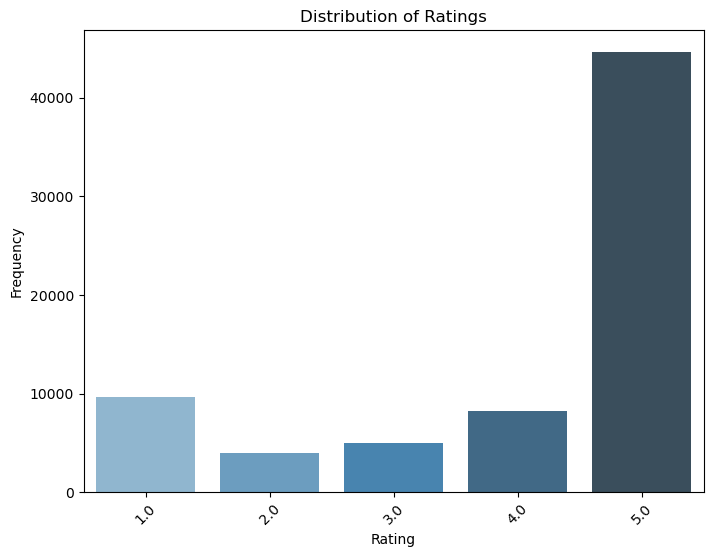

In [16]:
ratings = list(rating_counts.keys())
counts = list(rating_counts.values())
plt.figure(figsize=(8, 6))
sns.barplot(x=ratings, y=counts, palette='Blues_d')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Convert ratings to sentiment categories
sentiment = []
for rating in ratings:
    if rating in [1.0, 2.0]:
        sentiment.append("negative")
    elif rating == 3.0:
        sentiment.append("neutral")
    elif rating in [4.0, 5.0]:
        sentiment.append("positive")

# Analyze distribution
sentiment_counts = Counter(sentiment)
print("\nSentiment Category Distribution:")
for category, count in sentiment_counts.items():
    print(f"{category}: {count}")


Sentiment Category Distribution:
positive: 52826
negative: 13638
neutral: 5033


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


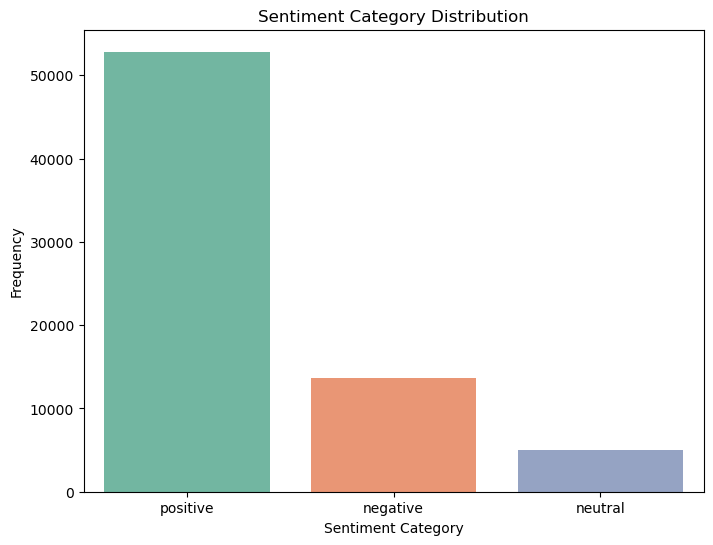

In [17]:
sentiment_labels = list(sentiment_counts.keys())
sentiment_values = list(sentiment_counts.values())
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_labels, y=sentiment_values, palette='Set2')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [11]:
# Group review lengths by sentiment
length_by_sentiment = {category: [] for category in ["positive", "neutral", "negative"]}

for item in reviews:
    text = item.get("text", "")
    rating = item.get("rating", None)
    if rating in [1.0, 2.0]:
        length_by_sentiment["negative"].append(len(text))
    elif rating == 3.0:
        length_by_sentiment["neutral"].append(len(text))
    elif rating in [4.0, 5.0]:
        length_by_sentiment["positive"].append(len(text))

# Analyze average lengths by sentiment
for category, lengths in length_by_sentiment.items():
    avg_length = sum(lengths) / len(lengths) if lengths else 0
    print(f"Average text length for {category} reviews: {avg_length:.2f}")

Average text length for positive reviews: 184.73
Average text length for neutral reviews: 290.11
Average text length for negative reviews: 315.89


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


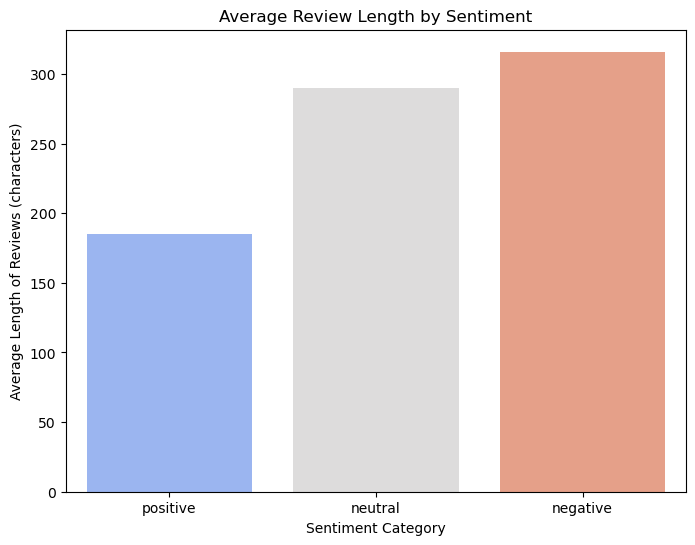

In [20]:
sentiment_labels = []
avg_lengths = []
for category, lengths in length_by_sentiment.items():
    avg_length = np.mean(lengths) if lengths else 0
    sentiment_labels.append(category)
    avg_lengths.append(avg_length)

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_labels, y=avg_lengths, palette='coolwarm')
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Length of Reviews (characters)')
plt.xticks(rotation=0)
plt.show()

In [13]:
helpful_by_sentiment = {category: [] for category in ["positive", "neutral", "negative"]}

for item in reviews:
    rating = item.get("rating", None)
    helpful_vote = item.get("helpful_vote", 0)
    if rating in [1.0, 2.0]:
        helpful_by_sentiment["negative"].append(helpful_vote)
    elif rating == 3.0:
        helpful_by_sentiment["neutral"].append(helpful_vote)
    elif rating in [4.0, 5.0]:
        helpful_by_sentiment["positive"].append(helpful_vote)

for category, votes in helpful_by_sentiment.items():
    avg_votes = sum(votes) / len(votes) if votes else 0
    print(f"Average helpful votes for {category} reviews: {avg_votes:.2f}")

Average helpful votes for positive reviews: 2.40
Average helpful votes for neutral reviews: 6.86
Average helpful votes for negative reviews: 11.52


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


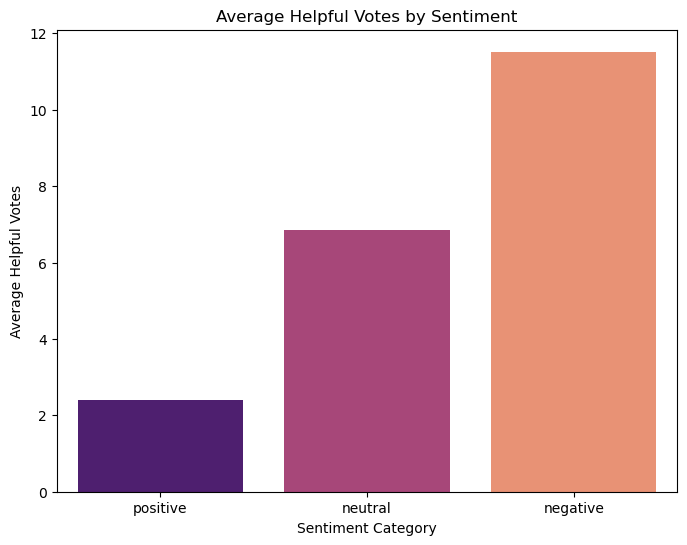

In [21]:
sentiment_labels = []
avg_helpful_votes = []
    
for category, votes in helpful_by_sentiment.items():
    avg_votes = np.mean(votes) if votes else 0
    sentiment_labels.append(category)
    avg_helpful_votes.append(avg_votes)

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_labels, y=avg_helpful_votes, palette='magma')
plt.title('Average Helpful Votes by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Helpful Votes')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Remove HTML tags and non-alphanumeric characters."""
    # Remove HTML tags (including <br>)
    text = re.sub(r'<.*?>', '', text)  # Removes all HTML tags
    # Remove non-alphanumeric characters (e.g., punctuation)
    text = re.sub(r'\W+', ' ', text)
    return text
    
def tokenize_with_stopwords(text):
    text = clean_text(text)
    return [word for word in re.findall(r'\w+', text.lower()) if word not in stop_words]

# Update the tokenization process
tokens_by_sentiment = {category: [] for category in ["positive", "neutral", "negative"]}

for item in reviews:
    text = item.get("text", "")
    rating = item.get("rating", None)
    tokens = tokenize_with_stopwords(text)
    if rating in [1.0, 2.0]:
        tokens_by_sentiment["negative"].extend(tokens)
    elif rating == 3.0:
        tokens_by_sentiment["neutral"].extend(tokens)
    elif rating in [4.0, 5.0]:
        tokens_by_sentiment["positive"].extend(tokens)

# Most common words per category (with stop words removed)
for category, tokens in tokens_by_sentiment.items():
    common_words = Counter(tokens).most_common(10)
    print(f"\nMost common words in {category} reviews (with stop words removed):")
    for word, count in common_words:
        print(f"{word}: {count}")

In [5]:
# Step 2: TF-IDF with N-grams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train and evaluate logistic regression with TF-IDF
log_reg_tfidf = LogisticRegression(max_iter=500, random_state=42)
log_reg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf)
print("TF-IDF Classification Report:\n", report_tfidf)

TF-IDF Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.73      0.73      1148
     Neutral       0.45      0.10      0.17       414
    Positive       0.90      0.96      0.93      4438

    accuracy                           0.86      6000
   macro avg       0.69      0.60      0.61      6000
weighted avg       0.83      0.86      0.84      6000



In [6]:

# Step 3: Word2Vec
# Tokenize sentences for Word2Vec training
tokenized_sentences = [text.split() for text in X_sample]
word2vec = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Create document embeddings by averaging Word2Vec vectors
def get_doc_embeddings(texts, model, embedding_dim=100):
    embeddings = []
    for text in texts:
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(embedding_dim))
    return np.array(embeddings)

X_train_w2v = get_doc_embeddings(X_train, word2vec)
X_test_w2v = get_doc_embeddings(X_test, word2vec)

# Train and evaluate logistic regression with Word2Vec
log_reg_w2v = LogisticRegression(max_iter=500, random_state=42)
log_reg_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = log_reg_w2v.predict(X_test_w2v)

# Evaluate Word2Vec
conf_matrix_w2v = confusion_matrix(y_test, y_pred_w2v)
report_w2v = classification_report(y_test, y_pred_w2v)
print("Word2Vec Classification Report:\n", report_w2v)

Word2Vec Classification Report:
               precision    recall  f1-score   support

    Negative       0.61      0.49      0.55      1148
     Neutral       0.31      0.04      0.07       414
    Positive       0.84      0.95      0.89      4438

    accuracy                           0.80      6000
   macro avg       0.59      0.49      0.50      6000
weighted avg       0.76      0.80      0.77      6000



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
# Step 4: Combine TF-IDF and Word2Vec
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_w2v])
X_test_combined = hstack([X_test_tfidf, X_test_w2v])

# Train and evaluate logistic regression with combined features
log_reg_combined = LogisticRegression(max_iter=500, random_state=42)
log_reg_combined.fit(X_train_combined, y_train)
y_pred_combined = log_reg_combined.predict(X_test_combined)


In [43]:

conf_matrix_combined = confusion_matrix(y_test, y_pred_combined)
report_combined = classification_report(y_test, y_pred_combined)
print("Combined Features Classification Report:\n", report_combined)
plt.figure(figsize=(18, 6))

Combined Features Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.74      0.73      1148
     Neutral       0.44      0.12      0.19       414
    Positive       0.90      0.96      0.93      4438

    accuracy                           0.86      6000
   macro avg       0.69      0.61      0.62      6000
weighted avg       0.84      0.86      0.84      6000



<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

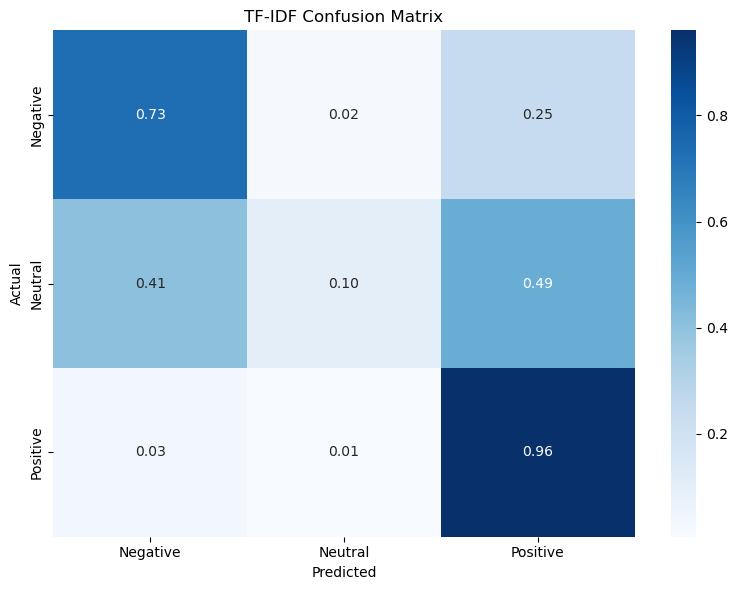

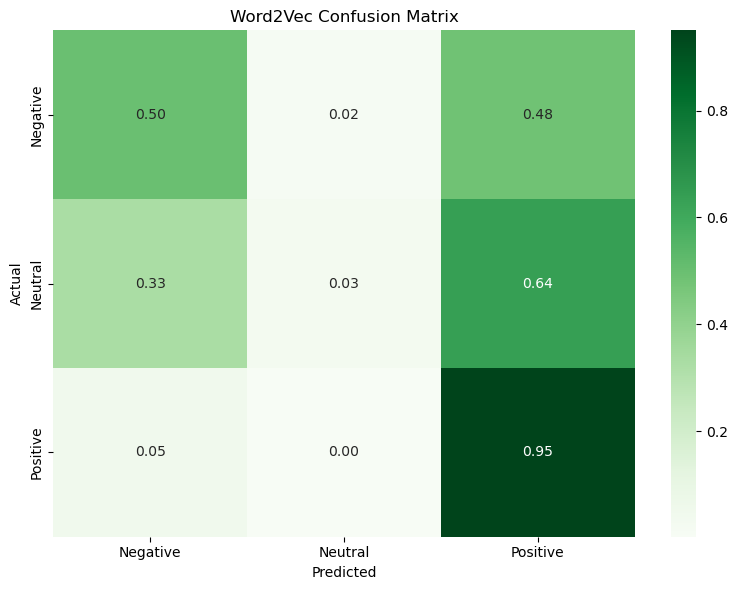

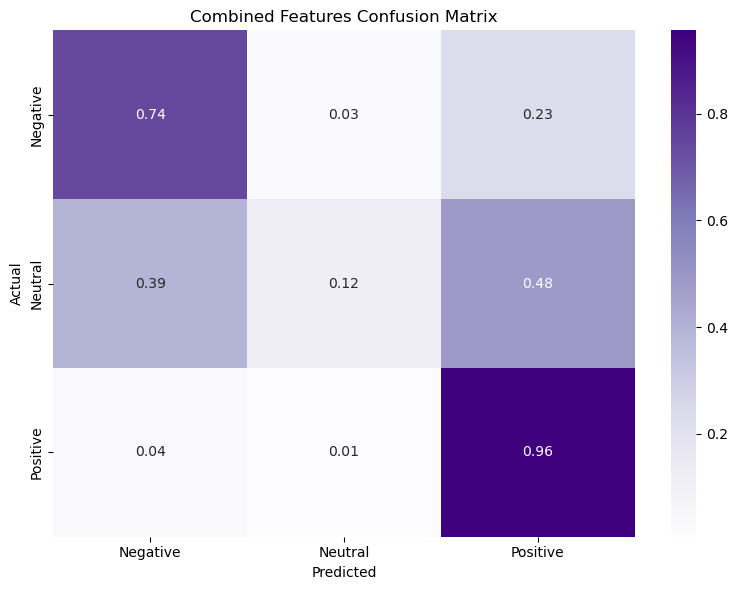

In [44]:
# Plot Confusion Matrices with Adjustments
def plot_confusion_matrix(conf_matrix, title, classes, cmap, normalize=False):
    """
    Function to plot a single confusion matrix with options for normalization.
    """
    plt.figure(figsize=(8, 6))
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
    else:
        fmt = "d"
    sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(conf_matrix_tfidf, "TF-IDF Confusion Matrix", log_reg_tfidf.classes_, "Blues", normalize=True)
plot_confusion_matrix(conf_matrix_w2v, "Word2Vec Confusion Matrix", log_reg_w2v.classes_, "Greens", normalize=True)
plot_confusion_matrix(conf_matrix_combined, "Combined Features Confusion Matrix", log_reg_combined.classes_, "Purples", normalize=True)


In [45]:
from sklearn.metrics import accuracy_score

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf) * 100
accuracy_w2v = accuracy_score(y_test, y_pred_w2v) * 100
accuracy_combined = accuracy_score(y_test, y_pred_combined) * 100

# Print the accuracies
print(f"TF-IDF Model Accuracy: {accuracy_tfidf:.2f}%")
print(f"Word2Vec Model Accuracy: {accuracy_w2v:.2f}%")
print(f"Combined Features Model Accuracy: {accuracy_combined:.2f}%")


TF-IDF Model Accuracy: 85.73%
Word2Vec Model Accuracy: 80.03%
Combined Features Model Accuracy: 85.77%


Best Parameters: {'C': 10, 'max_iter': 200, 'solver': 'liblinear'}
Optimized Logistic Regression Classification Report:
               precision    recall  f1-score   support

    Negative       0.73      0.74      0.74      1148
     Neutral       0.45      0.16      0.23       414
    Positive       0.90      0.95      0.93      4438

    accuracy                           0.86      6000
   macro avg       0.69      0.62      0.63      6000
weighted avg       0.84      0.86      0.84      6000



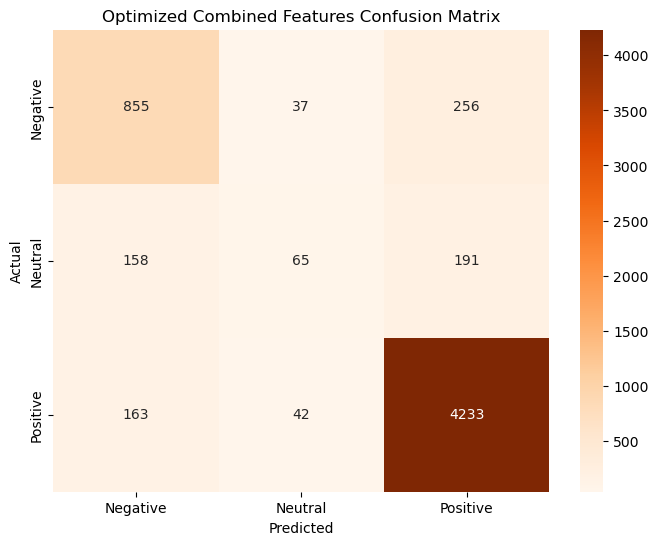

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack

# Step 1: Scale Word2Vec Features
scaler = StandardScaler()
X_train_w2v_scaled = scaler.fit_transform(X_train_w2v)
X_test_w2v_scaled = scaler.transform(X_test_w2v)

# Step 2: Weighted Combination of Features
# Give 70% weight to TF-IDF and 30% weight to Word2Vec
tfidf_weight = 0.7
w2v_weight = 0.3
X_train_combined_weighted = hstack([X_train_tfidf.multiply(tfidf_weight), X_train_w2v_scaled * w2v_weight])
X_test_combined_weighted = hstack([X_test_tfidf.multiply(tfidf_weight), X_test_w2v_scaled * w2v_weight])

# Step 3: Hyperparameter Tuning for Logistic Regression
param_grid = {
    'C': [10],  # Regularization strength
    'solver': ['liblinear'],  # Solver options
    'max_iter': [200]
}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined_weighted, y_train)

# Best Logistic Regression Model
best_log_reg = grid_search.best_estimator_

# Step 4: Evaluate the Optimized Model
y_pred_optimized = best_log_reg.predict(X_test_combined_weighted)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
report_optimized = classification_report(y_test, y_pred_optimized)

# Print Results
print(f"Best Parameters: {grid_search.best_params_}")
print("Optimized Logistic Regression Classification Report:\n", report_optimized)

# Step 5: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimized, annot=True, fmt="d", cmap="Oranges",
            xticklabels=best_log_reg.classes_, yticklabels=best_log_reg.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Combined Features Confusion Matrix")
plt.show()